# pybacktest tutorial

This tutorial will give you a quick overview of **pybacktest**'s features. To do so, we will backtest classic MA crossover trading strategy:

* go long when short MA crosses above long MA
* go short when short MA crosses below long MA
* entry rules are also exit rules, thus making strategy reversible

Package is available for download at https://github.com/ematvey/pybacktest

In [1]:
from __future__ import print_function

import pybacktest  # obviously, you should install pybacktest before importing it
import pandas as pd

**pybacktest** expects bars to be in `pandas.DataFrame` indexed by datetimestamps, with columns named `O`, `H`, `L`, `C`. Actually, in this version it would only check `O`, and only if trade prices are not explicitly specified.

Lets load data from yahoo using helper.

In [2]:
ohlc = pybacktest.load_from_yahoo('SPY')
ohlc.tail()

,H,L,O,C,V
Date,,,,,
2020-11-03,338.250000,330.290009,333.690002,336.029999,93294200.0
2020-11-04,347.940002,339.589996,340.859985,343.540009,126959700.0
2020-11-05,352.190002,348.859985,349.239990,350.239990,82039700.0
2020-11-06,351.510010,347.649994,349.929993,350.160004,74973000.0
2020-11-09,364.380005,354.059998,363.970001,354.559998,171760300.0


Now time to define strategy. To do so, all we need to do is to create binary `Series` with signals, and, optionally, trade price `Series` with float elements.

Could this be any simpler?

In [3]:
short_ma = 50
long_ma = 200

ms = ohlc.C.rolling(short_ma).mean()
ml = ohlc.C.rolling(long_ma).mean()
    
buy = cover = (ms > ml) & (ms.shift() < ml.shift())  # ma cross up
sell = short = (ms < ml) & (ms.shift() > ml.shift())  # ma cross down

print('>  Short MA\n%s\n' % ms.tail())
print('>  Long MA\n%s\n' % ml.tail())
print('>  Buy/Cover signals\n%s\n' % buy.tail())
print('>  Short/Sell signals\n%s\n' % sell.tail())

>  Short MA
Date
2020-11-03    338.823324
2020-11-04    338.839164
2020-11-05    338.920280
2020-11-06    338.984656
2020-11-09    339.092211
Name: C, dtype: float64

>  Long MA
Date
2020-11-03    310.349252
2020-11-04    310.433691
2020-11-05    310.549757
2020-11-06    310.679964
2020-11-09    310.858148
Name: C, dtype: float64

>  Buy/Cover signals
Date
2020-11-03    False
2020-11-04    False
2020-11-05    False
2020-11-06    False
2020-11-09    False
Name: C, dtype: bool

>  Short/Sell signals
Date
2020-11-03    False
2020-11-04    False
2020-11-05    False
2020-11-06    False
2020-11-09    False
Name: C, dtype: bool



Time to run backtest. `Backtest` will try to extract signals and prices and bars from whatever dict-like object you passed as first argument. Could be dict, could be pandas.DataFrame or anything.

To make thing easier, pass local namespace (extracted py calling `locals()`), that contains every variable you created up to this point.

In [4]:
bt = pybacktest.Backtest(locals(), 'ma_cross')

`Backtest` runs lazily, i.e. it calculates anything only when you call properties from it. There properties: 

In [5]:
print(list(filter(lambda x: not x.startswith('_'), dir(bt))))
print('\n>  bt.signals\n%s' % bt.signals.tail())
print('\n>  bt.trades\n%s' % bt.trades.tail())
print('\n>  bt.positions\n%s' % bt.positions.tail())
print('\n>  bt.equity\n%s' % bt.equity.tail())
print('\n>  bt.trade_price\n%s' % bt.trade_price.tail())

['dataobj', 'default_price', 'eqplot', 'equity', 'name', 'ohlc', 'plot_equity', 'plot_trades', 'positions', 'prices', 'report', 'run_time', 'signals', 'sigplot', 'stats', 'summary', 'trade_price', 'trades', 'trdplot']

>  bt.signals
              Buy   Sell  Short  Cover
Date                                  
2020-11-03  False  False  False  False
2020-11-04  False  False  False  False
2020-11-05  False  False  False  False
2020-11-06  False  False  False  False
2020-11-09  False  False  False  False

>  bt.trades
            pos       price  vol
Date                            
2016-04-21  1.0  192.577252  2.0
2018-12-13 -1.0  256.369287 -2.0
2019-03-27  1.0  273.180650  2.0
2020-04-01 -1.0  245.909156 -2.0
2020-07-07  1.0  314.122588  2.0

>  bt.positions
Date
2016-04-20    1.0
2018-12-12   -1.0
2019-03-26    1.0
2020-03-31   -1.0
2020-07-06    1.0
dtype: float64

>  bt.equity
Date
2016-04-21   -19.370214
2018-12-13    63.792036
2019-03-27   -16.811363
2020-04-01   -27.271494
2020-07

Some of popular performance statistics could be requested by calling `summary` method of `Backtest`.

In [6]:
bt.summary()

----------------------------------------------
|  Backtest(ma_cross, 2020-10-11 13:49 IST)  |
----------------------------------------------

backtest:
  days: 9440
  from: '1994-09-02 00:00:00'
  to: '2020-07-07 00:00:00'
  trades: 25
performance:
  PF: 1.5383
  RF: 0.9592
  averages:
    gain: 25.6501
    loss: -15.3917
    trade: 4.3084
  payoff: 1.6665
  profit: 107.71
  winrate: 0.48
risk/return profile:
  MPI: 0.0127
  UPI: 0.1586
  WCDD (monte-carlo 0.99 quantile): 143.8435
  maxdd: 112.2963
  sharpe: 0.1261
  sortino: 0.0103

----------------------------------------------


Now lets look at equity curve.

(<Figure size 1080x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Backtest(ma_cross, 2020-10-11 13:49 IST)'}, xlabel='Date', ylabel='Equity for slice(None, None, None)'>)

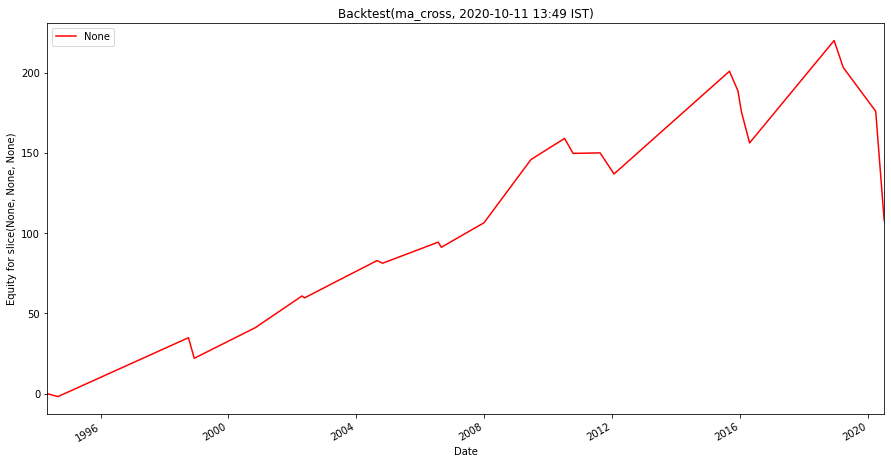

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

bt.plot_equity()

But what if you want to see what exactly was going on during backtest run? Well, `Backtest` can plot trades as they happened for you. Legend is hidden by default to save space.

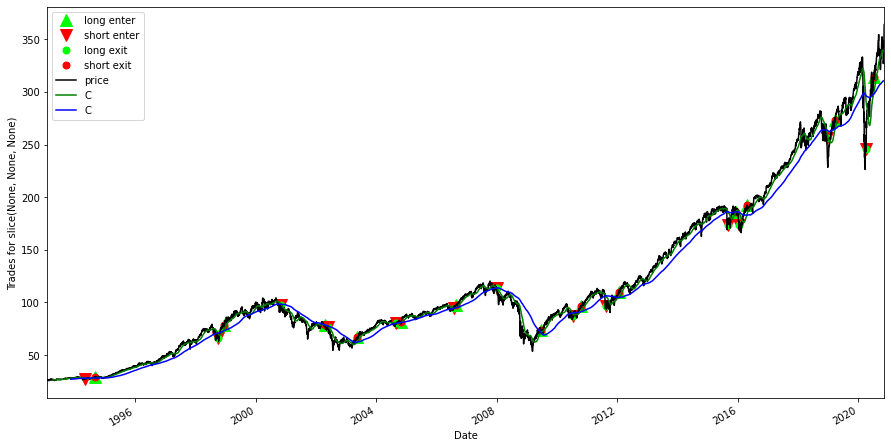

In [8]:
bt.plot_trades()
ohlc.C.rolling(short_ma).mean().plot(c='green')
ohlc.C.rolling(long_ma).mean().plot(c='blue')
plt.legend(loc='upper left')
pass

Can you see anything there? I can't. That's why we have special a very special `trdplot` property, which allowes you specify what period do you want to plot using standard `pandas` indexing mechanisms. Same trick could be done with equity curve using `eqplot` property.

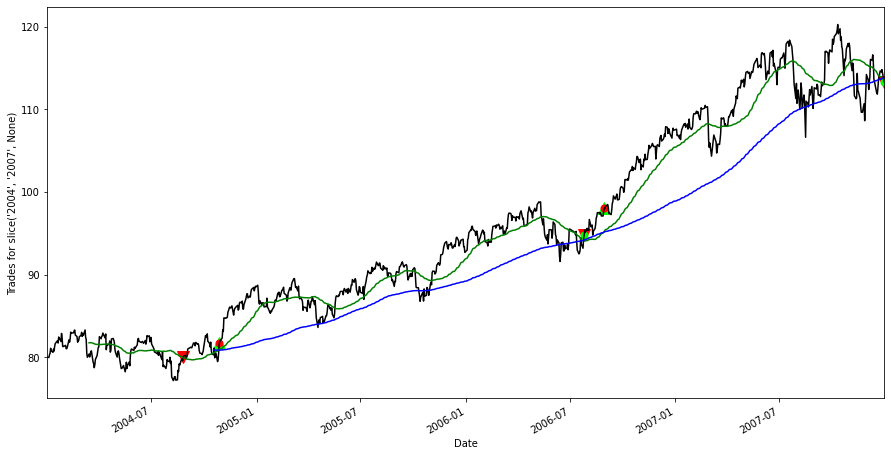

In [9]:
bt.trdplot['2004':'2007']
ohlc.C['2004':'2007'].rolling(short_ma).mean().plot(c='green')
ohlc.C['2004':'2007'].rolling(long_ma).mean().plot(c='blue')
pass

That's the most of it.